## Hereditary Geometry Discovery

- Simultaneously learn:
    - 1. Tensor that aligns Kernels (the left-action).
    - 2. Learn generator W that contains log of left-actions.
- Not implemented yet:
    - 1. Charts
    - 2. Symmetry Penalizer

In [1]:
import pickle
import os

from src.utils import load_replay_buffer
from src.learning.symmetry_discovery.differential.kernel_approx import KernelFrameEstimator

FOLDER_NAME: str="data/local/experiment/circle_rotation"
TASK_NAMES=["sac_circle_rotation_task_0", "sac_circle_rotation_task_1", "sac_circle_rotation_task_2", "sac_circle_rotation_task_3"]

LOAD_WHAT:str="next_observations"
KERNEL_DIM=1
N_SAMPLES=50_000


def load_replay_buffer_and_kernel(task_name:str, load_what:str, kernel_dim: int, n_samples:int, folder_name):
    """Loads samples and kernel evaluator of a task."""

    assert load_what in ["observations", "actions", "next_observations"], "Learn hereditary geometry for states, actions or next states."

    buffer_name= os.path.join(folder_name, f"{task_name}_replay_buffer.pkl")
    kernel_name= os.path.join(folder_name, f"{task_name}_kernel_bases.pkl")


    buffer= load_replay_buffer(buffer_name, N_steps=n_samples)
    ps=buffer[load_what]
    print(f"Loaded {load_what} from {buffer_name} with shape {ps.shape}")

    # Load kernel bases
    frameestimator=KernelFrameEstimator(ps=ps, kernel_dim=kernel_dim)
    with open(kernel_name, 'rb') as f:
        kernel_samples = pickle.load(f)
    frameestimator.set_frame(frame=kernel_samples)

    return ps, frameestimator

tasks_ps, tasks_frameestimators=[], []
for task_name in TASK_NAMES:
    ps, frameestimator = load_replay_buffer_and_kernel(task_name, LOAD_WHAT, KERNEL_DIM, N_SAMPLES, FOLDER_NAME)
    tasks_ps.append(ps)
    tasks_frameestimators.append(frameestimator)

2025-07-09 14:03:17.211483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_0_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_1_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_2_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_3_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


In [2]:
import torch
SEED=39
train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])},
 {'goal': torch.tensor([-0.81394263, -0.58094525])}]

In [62]:
%load_ext autoreload
%autoreload 2
from src.learning.symmetry_discovery.differential.hereditary_geometry_discovery import HereditaryGeometryDiscovery
ORACLE_KERNEL=True



her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,tasks_frameestimators=tasks_frameestimators, kernel_dim=KERNEL_DIM, batch_size=128, seed=SEED, bandwidth=0.5,
                                        task_specifications=train_goal_locations,use_oracle_rotation_kernel=ORACLE_KERNEL,
                                        log_lg_inits_how="log_linreg")
her_geo_dis.optimize(n_steps=10_000)

INFO:root:Fitting log-linear regressors to initialize left actions.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Inferring left-action:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in self.task_idxs])
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Generator Span Loss: 0.0:  84%|████████▎ | 8358/10000 [00:25<00:05, 325.60it/s]             


KeyboardInterrupt: 

In [61]:
her_geo_dis.generator

Parameter containing:
tensor([[[ 1.1823e-05, -9.0465e-01],
         [ 9.0475e-01,  3.2155e-06]]], requires_grad=True)

In [42]:
#Oracle rotation matrices
import torch

def rotation_matrix_2d(v, u):
    v = v / torch.norm(v)
    u = u / torch.norm(u)
    c = torch.dot(u, v)
    s = u[0] * v[1] - u[1] * v[0]  # 2D scalar cross product
    R = torch.tensor([[c, -s],
                      [s,  c]])
    return R


v1 = train_goal_locations[0]['goal']
v2 = train_goal_locations[1]['goal']
v3 = train_goal_locations[2]['goal']
v4 = train_goal_locations[3]['goal']

R_11 = rotation_matrix_2d(v1, v1)  # Rotates v2 to v1 direction
R_21 = rotation_matrix_2d(v2, v1)  # Rotates v2 to v1 direction
R_31 = rotation_matrix_2d(v3, v1)  # Rotates v3 to v1 direction
R_41 = rotation_matrix_2d(v4, v1)  # Rotates v3 to v1 direction
ground_truth_rotations=[R_11, R_21, R_31, R_41]
oracle_rotations_th=torch.tensor(torch.stack(ground_truth_rotations[1:]))

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_38954/1115610737.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  oracle_rotations_th=torch.tensor(torch.stack(ground_truth_rotations[1:]))


In [6]:
her_geo_dis.evalute_left_actions(lgs=oracle_rotations_th, track_loss=False)
print("Loss of each task using ground-truth left-action (should be low)", her_geo_dis.task_losses)

Loss of each task using ground-truth left-action (should be low) tensor([0.2679, 0.2679, 0.2679])


/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_36011/3681899776.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  her_geo_dis.evalute_left_actions(lgs=torch.tensor(torch.stack(ground_truth_rotations[1:])), track_loss=False)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

for idx_task in range(len(tasks_ps)-1):
    plt.plot(np.array(her_geo_dis._losses)[::100, idx_task], label=f"Task 0->{idx_task+1}")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Hereditary Geometry Discovery Losses (only left-actions)")
plt.show()

NameError: name 'her_geo_dis' is not defined

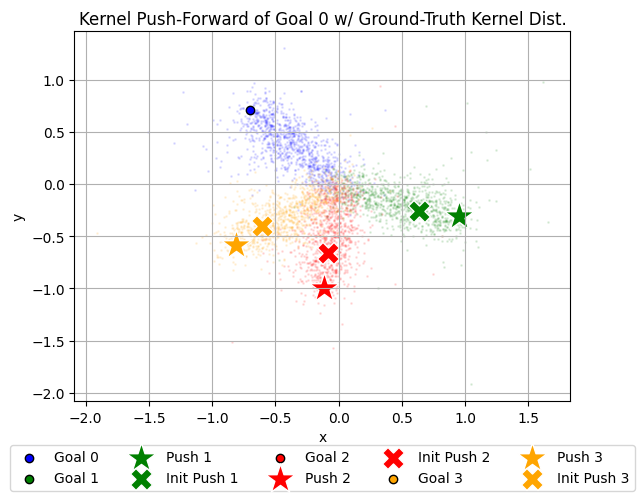

In [41]:
goal_0_pushed=torch.einsum("Nnm,m->Nn", her_geo_dis.lgs, train_goal_locations[0]["goal"]).detach().numpy()  # shape (n_tasks-1, b, n)
goal_0_pushed_init=torch.einsum("Nnm,m->Nn", her_geo_dis.lgs_inits, train_goal_locations[0]["goal"]).detach().numpy()  # shape (n_tasks-1, b, n)


PLOT_EVERY=100
colors= ['blue', 'green', 'red', 'orange']
for idx in range(len(tasks_ps)):
    plt.scatter(tasks_ps[idx][::PLOT_EVERY, 0], tasks_ps[idx][::PLOT_EVERY, 1], s=1, alpha=0.1, c=colors[idx])
    goal_location=train_goal_locations[idx]["goal"]
    
    plt.scatter(goal_location[0], goal_location[1], color=colors[idx], edgecolor='black', label=f'Goal {idx}')
    if idx > 0:
        plt.scatter(goal_0_pushed[idx-1, 0], goal_0_pushed[idx-1, 1], color=colors[idx], edgecolor='white', label=f'Push {idx}', marker="*", s=500)
        plt.scatter(goal_0_pushed_init[idx-1, 0], goal_0_pushed_init[idx-1, 1], color=colors[idx], edgecolor='white', label=f'Init Push {idx}', marker="X", s=250)

# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.title('Kernel Push-Forward of Goal 0 w/ Ground-Truth Kernel Dist.')
plt.grid()
plt.show()

## Compare Lassos

In [43]:
%load_ext autoreload
%autoreload 2
from src.learning.symmetry_discovery.differential.hereditary_geometry_discovery import HereditaryGeometryDiscovery
ORACLE_KERNEL=True

lasso_strenghts=[0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
N_RUNS=5
Seeds= [39, 42, 43, 44, 45]
N_TASKS=4
N_steps=10_000
losses_left_action=np.zeros((len(lasso_strenghts), N_RUNS, N_steps))
losses_generator_span=np.zeros((len(lasso_strenghts), N_RUNS, N_steps))
task_losses_left_action=np.zeros((len(lasso_strenghts), N_RUNS, N_steps, N_TASKS-1))
task_losses_left_action_reg=np.zeros((len(lasso_strenghts), N_RUNS, N_steps, N_TASKS-1))

for idx_lasso, lasso_strength in enumerate(lasso_strenghts):
    for idx_run, run in enumerate(range(N_RUNS)):
        print(f"Run {run+1}/{N_RUNS} for lasso strength {lasso_strength}")
        her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,tasks_frameestimators=tasks_frameestimators, kernel_dim=KERNEL_DIM, batch_size=128, seed=Seeds[idx_run], bandwidth=0.5,
                                                task_specifications=train_goal_locations,use_oracle_rotation_kernel=ORACLE_KERNEL,
                                                log_lg_inits_how="log_linreg", lasso_coef_lgs=lasso_strength)
        her_geo_dis.optimize(n_steps=N_steps)
        losses=her_geo_dis.losses
        del her_geo_dis

        losses_left_action[idx_lasso, run] = losses["left_actions"]
        losses_generator_span[idx_lasso, run] = losses["generator"]
        task_losses_left_action[idx_lasso, run] = losses["left_actions_tasks"]
        task_losses_left_action_reg[idx_lasso, run] = losses["left_actions_tasks_reg"]

INFO:root:Fitting log-linear regressors to initialize left actions.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Run 1/5 for lasso strength 0


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Inferring left-action:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in self.task_idxs])
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0. 0. 0.] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:30<00:00, 325.40it/s]                     
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 0


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0. 0. 0.] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:30<00:00, 323.00it/s]                     
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 0


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.023 | Task Losses: [0.07 0.   0.  ] | Task Losses (reg): [0.07 0.   0.  ] | Generator Span Loss: 0.423: 100%|██████████| 10000/10000 [00:29<00:00, 339.91it/s]     
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 0


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.031 | Task Losses: [0.042 0.    0.049] | Task Losses (reg): [0.042 0.    0.049] | Generator Span Loss: 0.325: 100%|██████████| 10000/10000 [00:29<00:00, 340.83it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 0


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.012 | Task Losses: [0.035 0.    0.   ] | Task Losses (reg): [0.035 0.    0.   ] | Generator Span Loss: 0.184: 100%|██████████| 10000/10000 [00:29<00:00, 333.61it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 1/5 for lasso strength 0.05


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.121 0.121 0.121] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 340.58it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 0.05


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.105 0.105 0.105] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:30<00:00, 325.41it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 0.05


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.019 | Task Losses: [0.056 0.    0.   ] | Task Losses (reg): [0.179 0.123 0.123] | Generator Span Loss: 0.275: 100%|██████████| 10000/10000 [00:29<00:00, 342.48it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 0.05


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.009 | Task Losses: [0.025 0.    0.   ] | Task Losses (reg): [0.147 0.122 0.122] | Generator Span Loss: 0.145: 100%|██████████| 10000/10000 [00:29<00:00, 341.04it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 0.05


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.105 0.105 0.105] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 341.97it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 1/5 for lasso strength 0.1


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.243 0.243 0.243] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 342.83it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 0.1


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.211 0.211 0.211] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 342.47it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 0.1


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.014 | Task Losses: [0.042 0.    0.   ] | Task Losses (reg): [0.285 0.244 0.244] | Generator Span Loss: 0.195: 100%|██████████| 10000/10000 [00:29<00:00, 341.08it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 0.1


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.005 | Task Losses: [0.014 0.    0.   ] | Task Losses (reg): [0.256 0.243 0.243] | Generator Span Loss: 0.075: 100%|██████████| 10000/10000 [00:29<00:00, 343.32it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 0.1


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.211 0.211 0.211] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 341.89it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 1/5 for lasso strength 0.2


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.485 0.485 0.485] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 343.20it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 0.2


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.421 0.421 0.421] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 342.85it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 0.2


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.007 | Task Losses: [0.021 0.    0.   ] | Task Losses (reg): [0.507 0.485 0.485] | Generator Span Loss: 0.097: 100%|██████████| 10000/10000 [00:29<00:00, 342.87it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 0.2


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.485 0.485 0.485] | Generator Span Loss: 0.002: 100%|██████████| 10000/10000 [00:29<00:00, 335.65it/s]          
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 0.2


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.421 0.421 0.421] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 343.49it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 1/5 for lasso strength 0.4


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.97 0.97 0.97] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 344.54it/s]               
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 0.4


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.842 0.842 0.842] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:28<00:00, 345.26it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 0.4


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.002 | Task Losses: [0.006 0.    0.   ] | Task Losses (reg): [0.976 0.97  0.97 ] | Generator Span Loss: 0.027: 100%|██████████| 10000/10000 [00:29<00:00, 343.28it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 0.4


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.97 0.97 0.97] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 343.92it/s]               
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 0.4


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [0.842 0.842 0.842] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 343.54it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 1/5 for lasso strength 0.8


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [1.94 1.94 1.94] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 341.61it/s]               
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 0.8


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [1.685 1.685 1.685] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 343.35it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 0.8


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [1.94 1.94 1.94] | Generator Span Loss: 0.001: 100%|██████████| 10000/10000 [00:29<00:00, 343.83it/s]             
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 0.8


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.376 | Task Losses: [0.    0.    1.129] | Task Losses (reg): [1.637 1.637 2.766] | Generator Span Loss: 0.181: 100%|██████████| 10000/10000 [00:29<00:00, 344.82it/s]           
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 0.8


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.0 | Task Losses: [0. 0. 0.] | Task Losses (reg): [1.685 1.685 1.685] | Generator Span Loss: 0.0: 100%|██████████| 10000/10000 [00:29<00:00, 344.56it/s]            
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 1/5 for lasso strength 1.6


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.634 | Task Losses: [0.84 1.06 0.  ] | Task Losses (reg): [1.944 2.164 1.104] | Generator Span Loss: 0.125: 100%|██████████| 10000/10000 [00:29<00:00, 344.21it/s]              
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 2/5 for lasso strength 1.6


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.765 | Task Losses: [1.000e-03 9.460e-01 1.347e+00] | Task Losses (reg): [1.476 2.422 2.822] | Generator Span Loss: 0.069: 100%|██████████| 10000/10000 [00:29<00:00, 339.10it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 3/5 for lasso strength 1.6


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.85 | Task Losses: [0.002 1.093 1.456] | Task Losses (reg): [1.988 3.079 3.441] | Generator Span Loss: 0.07: 100%|██████████| 10000/10000 [00:29<00:00, 343.83it/s]             
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 4/5 for lasso strength 1.6


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.821 | Task Losses: [1.000e-03 1.047e+00 1.415e+00] | Task Losses (reg): [1.997 3.043 3.411] | Generator Span Loss: 0.067: 100%|██████████| 10000/10000 [00:29<00:00, 343.23it/s]
INFO:root:Fitting log-linear regressors to initialize left actions.


Run 5/5 for lasso strength 1.6


INFO:root:Finished fitting log-linear regressors to initialize left actions.
Left-Action Loss: 0.787 | Task Losses: [1.000e-03 9.950e-01 1.366e+00] | Task Losses (reg): [1.477 2.471 2.843] | Generator Span Loss: 0.07: 100%|██████████| 10000/10000 [00:29<00:00, 343.19it/s]


In [28]:
losses_generator_span.shape

(5, 5, 10000)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_44998/3806319098.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm", len(lasso_strenghts))


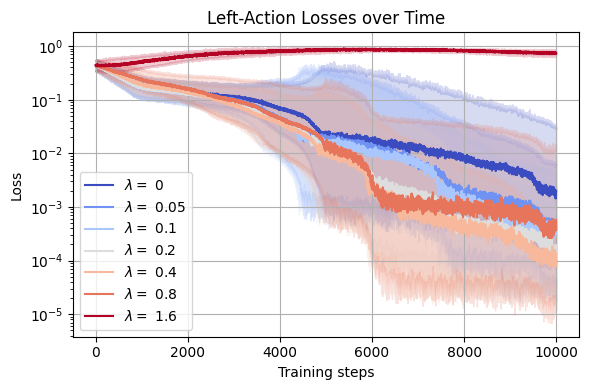

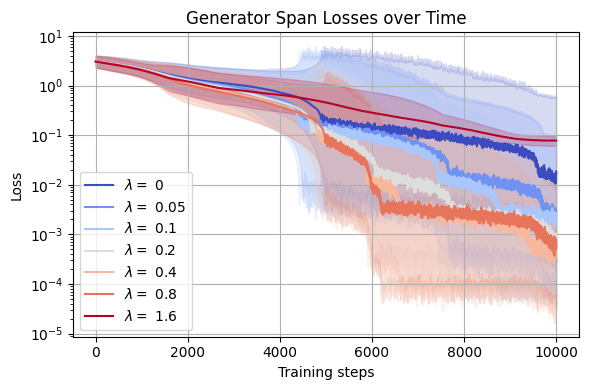

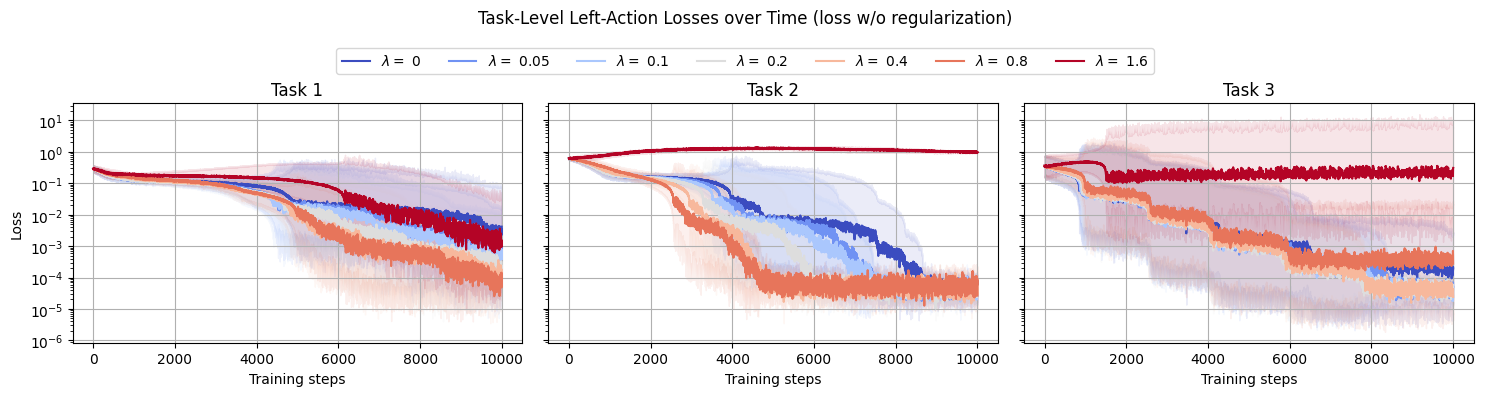

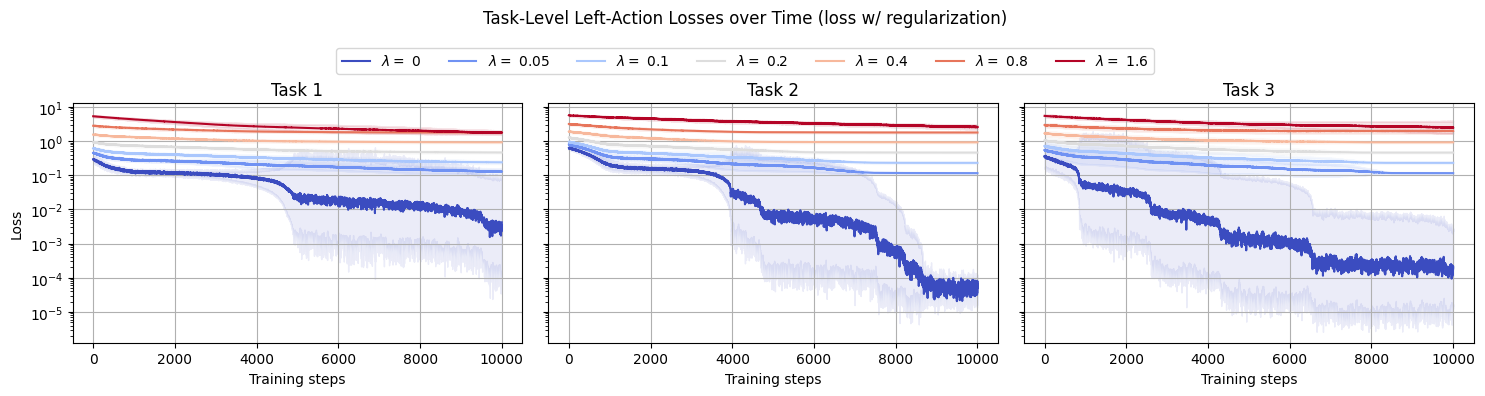

In [44]:
losses_left_action.shape

min_val = 1e-8
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_loss_over_time(array, title):
    cmap = cm.get_cmap("coolwarm", len(lasso_strenghts))
    min_val = 1e-8
    N_steps = array.shape[2]

    if array.ndim == 4 and array.shape[-1] == 3:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        task_names = ["Task 1", "Task 2", "Task 3"]
        for task in range(3):
            ax = axes[task]
            for idx_lasso, lasso_strength in enumerate(lasso_strenghts):
                losses = array[idx_lasso, :, :, task]
                log_mean = np.mean(np.log(losses + min_val), axis=0)
                log_std = np.std(np.log(losses + min_val), axis=0)

                lower = np.exp(log_mean - log_std)
                upper = np.exp(log_mean + log_std)
                mean = np.exp(log_mean)
                color = cmap(idx_lasso)

                label = f"$\lambda=$ {lasso_strength}" if task == 0 else None
                ax.plot(mean, label=label, color=color)
                ax.fill_between(np.arange(N_steps), lower, upper, alpha=0.1, color=color)

            ax.set_title(task_names[task])
            ax.set_xlabel("Training steps")
            ax.grid()
            ax.set_yscale("log")
        axes[0].set_ylabel("Loss")
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 0.9))
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.92])
        plt.show()

    else:
        plt.figure(figsize=(6, 4))
        for idx_lasso, lasso_strength in enumerate(lasso_strenghts):
            losses = array[idx_lasso]
            log_mean = np.mean(np.log(losses + min_val), axis=0)
            log_std = np.std(np.log(losses + min_val), axis=0)
            color = cmap(idx_lasso)

            lower = np.exp(log_mean - log_std)
            upper = np.exp(log_mean + log_std)
            mean = np.exp(log_mean)

            plt.plot(mean, label=f"$\lambda=$ {lasso_strength}", color=color)
            plt.fill_between(np.arange(N_steps), lower, upper, alpha=0.2, color=color)

        plt.grid()
        plt.yscale("log")
        plt.xlabel("Training steps")
        plt.ylabel("Loss")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()



plot_loss_over_time(losses_left_action, "Left-Action Losses over Time")
plot_loss_over_time(losses_generator_span, "Generator Span Losses over Time")
plot_loss_over_time(task_losses_left_action, "Task-Level Left-Action Losses over Time (loss w/o regularization)")
plot_loss_over_time(task_losses_left_action_reg, "Task-Level Left-Action Losses over Time (loss w/ regularization)")